In [34]:
import random
import scipy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize, minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
from distributions import southernUtah, saltLakeCity, sanDiego, twinCities, oneFarOneClose
from sca import sca_optimize_uav_circle

seed = 324
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed)

## Parameters
- $r$ = radius of the UAV's flight path
    -  $r_\text{min}$ = minimum radius of the UAV's flight path
    -  $r_\text{max}$ = maximum radius of the UAV's flight path
- $D$ = location of user distribution along x-axis
- $r_\text{D}$ = radius of user distribution
- $c_\text{x}$ = x-coordinate of the center point of the UAV's flight path
    - $c_\text{xmin}$ = minimum which $c_\text{x}$ can take
    - $c_\text{xmax}$ = maximum which $c_\text{x}$ can take
- $c_\text{y}$ = y-coordinate of the center point of the UAV's flight path
    - $c_\text{ymin}$ = minimum which $c_\text{y}$ can take
    - $c_\text{ymax}$ = maximum which $c_\text{y}$ can take
- $v$ = speed of the UAV
- $T$ = time it takes for the drone to complete one flight circle
    - $T_\text{max}$ = time it takes the drone to complete maximum flight circle
- $T_\text{C}$ = length of each timeslot
- $N$ = number of time slots
    - $N_\text{max}$ = number of timeslots in maximum flight circle
- $M$ = number of users that the UAV can serve simultaneously
- $K$ = total number of users = $M\cdot N$
    - $K_\text{max}$ = maximum number of users = $M\cdot N_\text{max}$
- $H$ = height of the UAV's flight path
- $P^\text{A}_\text{tx}$ = UAV transmission power
- $P^\text{U}_\text{tx}$ = user transmission power
- $G_\text{T}$ = antenna gain at transmitter
- $G_\text{R}$ = antenna gain at receiver
- $B$ = total bandwidth
- $N_\text{0}$ = noise power
- $f$ = signal frequency
- $\lambda$ = signal wavelength
- $\mathcal{U}_n$ = the list of user indices served in timeslot $N$

In [35]:
r_min = 1000 # meters
r_max = 5000 # meters
D = 15000 # meters
rD = 4000 # meters
cx_min = -10000 # meters
cx_max = 10000 # meters
cy_min = -10000
cy_max = 10000
v = 50 # meters/second
T = (2*np.pi*r_max)/v # seconds
TC = 1 # seconds
N = int(T // TC) # time slots
M = 2 # users
K = N*M # users
H = 100 # meters
PAtx = 1 # watts
PUtx = 0.07 # watts
GT = 1
GR = 1
B = 1e6 # Hz
N0 = 10**((7.5-174+10*np.log10(B))/10)/1000 # watts
F = 2e9 # Hz
WAVELENGTH = scipy.constants.c / F # meters

# Create Un
idxs = np.arange(K)
np.random.shuffle(idxs)
Un = np.reshape(idxs, (N, M))

## Constants for convenience
- `thetas` = UAV angle at each timeslot
- `cos_th` = $\cos(\text{UAV angle at each timeslot})$
- `sin_th` = $\sin(\text{UAV angle at each timeslot})$
- `CU` = $P^\text{U}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `CA` = $P^\text{A}_\text{tx} G_\text{T} G_\text{R} \left(\frac{\lambda}{4\pi}\right)^2$
- `AU` = $\frac{C_\text{U}M}{N_0}$
- `AB` = $\frac{C_\text{A}}{N_0}$ 

In [36]:
thetas = 2*np.pi*np.arange(N)/N
cos_th = np.cos(thetas)
sin_th = np.sin(thetas)
CU = PUtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
CA = PAtx*GT*GR*(WAVELENGTH/(4*np.pi))**2
AU = (CU * M) / N0
AB = CA / N0

## User Generation
Here we define a function to randomly generate users within the deadzone. For the purposes of the simulation, we generate the maximum number of users. Smaller flight paths may not serve every user in one rotation, but the objective is normalized over timeslots. We plot the users at the end to verify that the distribution is correct.

len(users): 1256
K: 1256


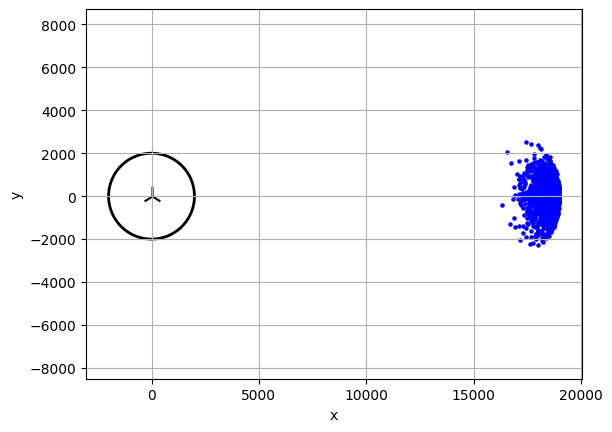

In [37]:
def generate_users(num_users, distribution='uniform'):
    users = []
    if (distribution == 'uniform'):
        for _ in range(num_users):
            r = rD * np.sqrt(random.random())
            theta = random.uniform(0, 2*np.pi)
            x = D + r * np.cos(theta)
            y = r * np.sin(theta)
    
            users.append((x, y))
    elif (distribution == 'skewed-normal'):
        x_mean = D + 5000
        y_mean = 0
        std_dev = 1000
        
        while (len(users) < num_users):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))
    elif (distribution == 'two-skewed-normal'):
        x_mean = D + 5000
        y_mean = 0
        std_dev = 1000
        
        while (len(users) < num_users*0.5):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))
        
        x_mean = D
        y_mean = -5000
        std_dev = 1000

        while (len(users) < num_users):
            x = rng.normal(loc=x_mean, scale=std_dev)
            y = rng.normal(loc=y_mean, scale=std_dev)

            if ((x - D)**2 + y**2 < rD**2):
                users.append((x, y))

    elif (distribution == 'one-far-one-close'):
        users = oneFarOneClose(num_users)
                         
    return np.asarray(users, dtype=float)

users = generate_users(K, distribution='skewed-normal')
print(f'len(users): {len(users)}')
print(f'K: {K}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
ax = plt.gca()  # get current axes
circle = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=2)
ax.add_patch(circle)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()

## Mean SE (objective function)
The average achievable spectral efficiency of the relay system over the timeslots is given as
$$\overline{\text{SE}}(\alpha, r, c_\text{x}, c_\text{y}) = \frac{1}{N}\sum_{n=0}^N \min\left[\alpha \cdot \frac{1}{M}\sum_{k\in\mathcal{U}_n}\text{SE}^\text{UA}_{n,k}\;\mathbf{,}\;(1-\alpha)\cdot\text{SE}^\text{AB}_n\right]$$

In [38]:
def meanSE(alpha, r, cx, cy):
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Calculate SEUA and SEAB
    ua_se = []
    for n in range(N):
        tmp = np.log2(1.0 + AU/snk0[n])
        ua_se.append( (alpha/M)*np.sum(tmp) )
    ab_se = (1-alpha)*np.log2(1.0 + AB/sbn0)

    # Calculate the mins
    min_se = [min(ua, ab) for ua, ab in zip(ua_se, ab_se)]

    # Return the average
    return (1/N) * np.sum(min_se)
    


## Baselines
Here I define two baselines to see how much improvement the optimizations are providing us. The two baselines are
1. Running 1000 trials with randomized $\alpha$, $r$, $c_\text{x}$, and $c_\text{y}$ (with $\alpha \in [0, 1]$, $r \in [r_\text{min}, r_\text{max}]$, $c_\text{x} \in [c_\text{xmin}, c_\text{xmax}]$, $c_\text{y} \in [c_\text{ymin}, c_\text{ymax}]$)
2. MeanSE with $\alpha=0.5$, $r=(r_\text{min}+r_\text{max})/2$, $c_\text{x}=\frac{c_\text{xmin} + c_\text{xmax}}{2}$, and $c_\text{y} = \frac{c_\text{ymin} + c_\text{ymax}}{2}$

In [39]:
random_total = 0
for _ in range(1000):
    random_total += meanSE(random.uniform(0, 1), 
                           random.uniform(r_min, r_max), 
                           random.uniform(cx_min, cx_max),
                           random.uniform(cy_min, cy_max))

print(f'Random baseline: {random_total / 1000}')

centered_baseline = meanSE(0.5,
                           (r_min + r_max)/2,
                           (cx_min + cx_max)/2,
                           (cy_min + cy_max)/2)

print(f'Centered baseline: {centered_baseline}')

Random baseline: 0.7153147747374582
Centered baseline: 0.9325396493510048


## $\alpha$ Optimizer
Here I will define an optimizer to find the optimal $\alpha$ for a fixed $r$, $c_\text{x}$, $c_\text{y}$.

In [40]:
def optimize_alpha(r, cx, cy):
    """
    Maximizes the timeshare for a given trajectory

    Returns alpha*
    """
    
    # Compute UAV position at each timeslot
    ax = cx + r*cos_th
    ay = cy + r*sin_th

    # Compute squared distances
    snk0 = []
    for n in range(N):
        idxs = np.asarray(Un[n], dtype=int)
        dx = ax[n] - users[idxs, 0]
        dy = ay[n] - users[idxs, 1]
        snk0.append(dx*dx + dy*dy + H*H)
    sbn0 = (ax*ax + ay*ay + H*H)

    # Compute an and bn
    an = []
    for n in range(N):
        tmp = np.log2(1.0 + AU/snk0[n])
        an.append(np.sum(tmp))
    bn = np.log2(1.0 + AB/sbn0)

    # Compute qns
    qn = bn / (an + bn)
    qn = np.append(qn, [0, 1])

    # Find optimal qn
    se_qn = [(meanSE(q, r, cx, cy), q) for q in qn]
    return max(se_qn)[1]

## Powell's optimizer for $\alpha$, $r$, $c_\text{x}$, $c_\text{y}$
Here I define a block optimizer to iteratively optimize $\alpha$, $r$, $c_\text{x}$, and $c_\text{y}$.

Iteration 1
Optimization terminated successfully.
Iteration 2
Optimization terminated successfully.
Iteration 3
Optimization terminated successfully.
Optimal alpha: 0.5110442982639639
Optimal radius: 2923.980970591149
Optimal center point: (9999.934867841306, -29.39238566952248)
Achievable SE: 1.9246529806354167


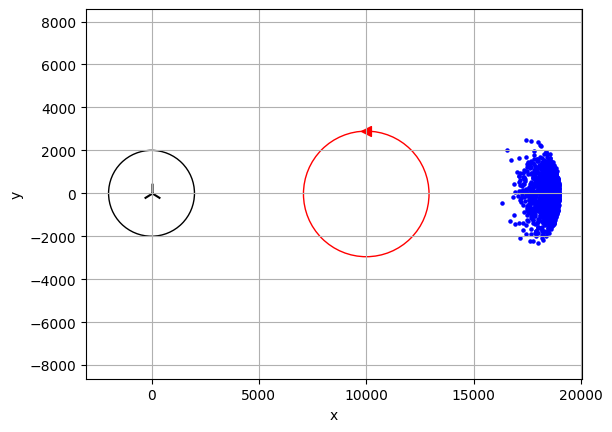

In [41]:
def objective(params, alpha):
    r, cx, cy = params
    return -meanSE(alpha, r, cx, cy)

def powells_optimizer(
                    alpha0, 
                    r0, 
                    cx0, 
                    cy0, 
                    rbounds,
                    cxbounds,
                    cybounds,
                    tolerance=1e-3
):
    # Initialize values
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0
    bounds = [rbounds, cxbounds, cybounds]


    obj_history = [meanSE(alpha, r, cx, cy)]

    it = 0
    while True:
        it += 1
        print(f'Iteration {it}')

        alpha = optimize_alpha(r, cx, cy)

        result = minimize(
                    objective,
                    [r,cx,cy],
                    args=(alpha),
                    method='Powell',
                    bounds=bounds,
                    options={
                        'maxiter':1000,
                        'xtol':1e-3,
                        'ftol':1e-3
                    }
                )
        print(result.message)

        r, cx, cy = result.x

        obj_history.append(meanSE(alpha, r, cx, cy))

        if ( (obj_history[-1] - obj_history[-2])/obj_history[-2] < tolerance):
            break
    
    return alpha, r, cx, cy
        
alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, r_opt, cx_opt, cy_opt = powells_optimizer(
                                                    alpha0, 
                                                    r0, 
                                                    cx0, 
                                                    cy0, 
                                                    (r_min, r_max),
                                                    (cx_min, cx_max),
                                                    (cy_min, cy_max))
print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)
ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()


## Successive convex approximation

Optimizer iteration 0
    SCA iteration 0
    SCA iteration 1
    SCA iteration 2
alpha: 0.48966748318696873, radius: 1000.0000710225065, center: (9874.975001397806, -14.649173765905045)
Optimizer iteration 1
    SCA iteration 0
    SCA iteration 1
    SCA iteration 2
Optimal alpha: 0.4897458166153866
Optimal radius: 1000.0001382581182
Optimal center point: (9872.537875935748, -14.624585413623631)
Achievable SE: 1.8207663692223754


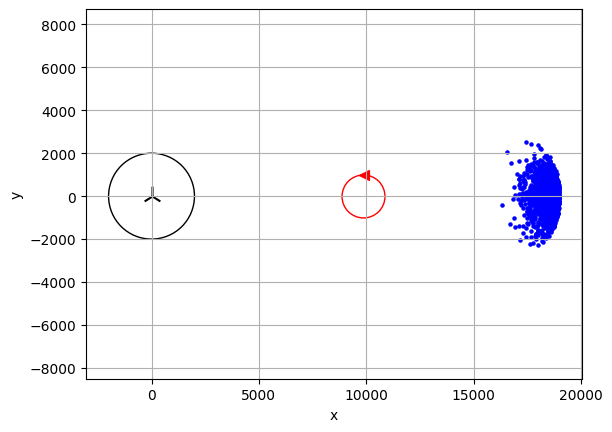

In [ ]:
def sca_optimizer(alpha0, 
                r0, 
                cx0, 
                cy0,
                r_bounds, 
                cx_bounds, 
                cy_bounds,
                sca_tol=1e-3,
                max_sca_iters=30,
                overall_tol=1e-3,
                verbose=True
):
    
    alpha = alpha0
    r = r0
    cx = cx0
    cy = cy0

    def f_and_grad(s, A):
        """Return f(s)=log2(1+A/s) and f'(s) = -A/(ln2*s*(s+A)) elementwise."""
        s = np.asarray(s, dtype=float)
        f = np.log2(1.0 + A/np.maximum(s,1e-18))
        fp = -(A) / (np.log(2.0) * np.maximum(s,1e-18) * (np.maximum(s,1e-18) + A))
        return f, fp
    
    overall_obj_hist = []
    overall_it = 0
    while True:
        print(f'Optimizer iteration {overall_it}')

        sca_obj_hist = []
        sca_it = 0
        for sca_it in range(max_sca_iters):
            print(f'    SCA iteration {sca_it}')

            # Compute UAV coords
            ax = cx + r*cos_th
            ay = cy + r*sin_th

            # Compute squared distances
            snk0 = []
            for n in range(N):
                idxs = np.asarray(Un[n], dtype=int)
                dx = ax[n] - users[idxs,0]
                dy = ay[n] - users[idxs,1]
                snk0.append(dx*dx + dy*dy + H*H)
            sbn0 = (ax*ax + ay*ay + H*H)            

            # Evaluate f and gradients at current s
            fU0 = []
            gU0 = []
            for n in range(N):
                fu, gu = f_and_grad(snk0[n], AU)
                fU0.append(fu)
                gU0.append(gu)
            fB0, gB0 = f_and_grad(sbn0, AB)

            # CVXPY variables
            r_var  = cp.Variable()
            cx_var = cp.Variable()
            cy_var = cp.Variable()
            t = cp.Variable(N)  # timeslot min-SE terms

            # Auxiliary upper-bounds for squared distances
            s_vars = [cp.Variable(M) for n in range(N)]  # s_{n,k}
            sb_var = cp.Variable(N)  # b^2_n

            cons = []

            # Geometric "upper-bound" constraints: s >= true squared distance
            for n in range(N):
                # planar expressions are affine in (r,cx,cy)
                ax_n = cx_var + r_var*cos_th[n]
                ay_n = cy_var + r_var*sin_th[n]

                # user distances
                idxs = np.asarray(Un[n], dtype=int)
                xk = users[idxs,0]
                yk = users[idxs,1]

                # ||(ax_n - xk, ay_n - yk)||^2 + H^2  <=  s_vars[n]  (as lower-bound on SE we want s_vars >= true)
                # Implement via rotated quadratic cone: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                # In cvxpy, simple convex way is: s >= (ax_n - x)^2 + (ay_n - y)^2 + H^2
                cons += [ s_vars[n] >= (ax_n - xk)**2 + (ay_n - yk)**2 + (H**2) ]

                # AB link
                cons += [ sb_var[n] >= (ax_n)**2 + (ay_n)**2 + (H**2) ]
            
            # Linearized (conservative) SE constraints per slot:
            # t_n <= (alpha/M) sum_k [ fU0 + gU0 * (s - s0) ]
            # t_n <= (1-alpha)      [ fB0 + gB0 * (sb - sb0) ]
            for n in range(N):
                # UA side
                f0 = fU0[n]         # shape (M,)
                g0 = gU0[n]         # shape (M,)
                s0 = snk0[n]       # shape (M,)
                cons += [
                    t[n] <= (alpha/M) * ( cp.sum(f0) + g0 @ (s_vars[n] - s0) )
                ]

                # AB side
                cons += [
                    t[n] <= (1.0 - alpha) * ( fB0[n] + gB0[n] * (sb_var[n] - sbn0[n]) )
                ]
            
            # Add parameter bounds
            r_min, r_max = r_bounds
            cons += [ r_var >= r_min, r_var <= r_max ]
            
            cx_min, cx_max = cx_bounds
            cons += [ cx_var >= cx_min, cx_var <= cx_max ]
            
            cy_min, cy_max = cy_bounds
            cons += [ cy_var >= cy_min, cy_var <= cy_max ]

            # Solve objective
            obj = cp.Maximize( cp.sum(t) / N )
            prob = cp.Problem(obj, cons)
            prob.solve(solver=cp.MOSEK, verbose=verbose)

            if prob.status not in ("optimal", "optimal_inaccurate"):
                raise RuntimeError(f"    SCA subproblem infeasible/failed at iter {sca_it}: status {prob.status}")
            
            # Update iterate
            r = float(r_var.value)
            cx = float(cx_var.value)
            cy = float(cy_var.value)

            sca_obj_hist.append(float(np.sum(t.value)/N))

            if sca_it > 0:
                # Convergence check (relative improvement in objective)
                if (sca_obj_hist[-1] - sca_obj_hist[-2])/max(1e-9, abs(sca_obj_hist[-2])) < sca_tol:
                    break
        
        alpha = optimize_alpha(r, cx, cy)
        
        overall_obj_hist.append(meanSE(alpha, r, cx, cy))

        if overall_it > 0:
            if (overall_obj_hist[-1] - overall_obj_hist[-2])/max(1e-9, abs(overall_obj_hist[-2])) < overall_tol:
                break
        
        print(f'alpha: {alpha}, radius: {r}, center: ({cx}, {cy})')
        overall_it += 1
    
    return alpha, r, cx, cy

alpha0 = 0.5
r0 = (r_min + r_max) / 2
cx0 = (cx_min + cx_max) / 2
cy0 = (cy_min + cy_max) / 2

alpha_opt, r_opt, cx_opt, cy_opt = sca_optimizer(
                                                alpha0,
                                                r0,
                                                cx0,
                                                cy0,
                                                (r_min, r_max),
                                                (cx_min, cx_max),
                                                (cy_min, cy_max),
                                                sca_tol=1e-6,
                                                overall_tol=1e-6,
                                                verbose=False)
print(f'Optimal alpha: {alpha_opt}')
print(f'Optimal radius: {r_opt}')
print(f'Optimal center point: ({cx_opt}, {cy_opt})')
print(f'Achievable SE: {meanSE(alpha_opt, r_opt, cx_opt, cy_opt)}')

xs, ys = zip(*users)
plt.scatter(xs, ys, c='b', marker='o', s=5)
plt.scatter(0, 0, c='black', marker='2', s=200, label="Origin")
plt.scatter(cx_opt, cy_opt+r_opt, c='r', marker='<', s=50, label="UAV")
ax = plt.gca()  # get current axes
coverage_zone = patches.Circle((0, 0), radius=2000, fill=False, color='black', linewidth=1)
flight_path = patches.Circle((cx_opt, cy_opt), radius=r_opt, fill=False, color='red', linewidth=1)
ax.add_patch(coverage_zone)
ax.add_patch(flight_path)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.axis("equal")  # equal scaling
plt.show()
